### Roberta(Robustly Optimized Bert pre-training Approach)

Roberta는 bert의 파생 모델 중 하나다. RoBERTa는 기본적으로 BERT와 동일하며, 사전 학습 시 아래 항목을 변경하였다.

- MLM 태스크에서 정적 마스킹이 아닌 동적 마스킹 방법 적용

- NSP태스크를 제거하고 MLM 태스크만 학습에 사용

- 배치 크기를 증가해 학습

- 토크나이저로 BBPE(byte-level BPE) 사용


위 내용에 대해 자세히 알아보자

#### 정적 마스크 대신 동적 마스크 사용

BERT의 MLM 태스크는 주어진 토큰의 15% 확률로 무작위로 마스크된 토큰으로 변경한 후 모델에서 해당 토큰을 예측한다.

예를들어 '우리는 아침 6시에 출근을 한다` 라는 문장이 있을때, 토크나이징 적용후 [CLS], [SEP] 토큰을 추가하면 아래와 같다.

tokens = [ [CLS], 우리, 는, 아침, 6시, 에, 출근, 을, 한다, [SEP]]

다음으로 15%를 랜덤으로 mask한다.

tokens = [ [CLS], 우리, 는, [MASK], [MASK], 에, 출근, 을, 한다, [SEP]]

이제 토큰을 BERT 모델에 입력해 마스크된 토큰을 예측하도록 학습한다. 이때 마스킹은 데이터 전처리 단계에서 한 번만 수행되며, epoch별로 동일한 마스킹을 예측하도록 모델 학습이 이뤄진다.
이것이 정적 마스킹이다.

그렇다면 RoBERTa는 어떻게 동적 마스킹을 사용할까 ?

- 하나의 문장을 10개로 복사
- 다음으로 10개의 문장에 대해 무작위로 15% 확률 마스크 작업을 수행

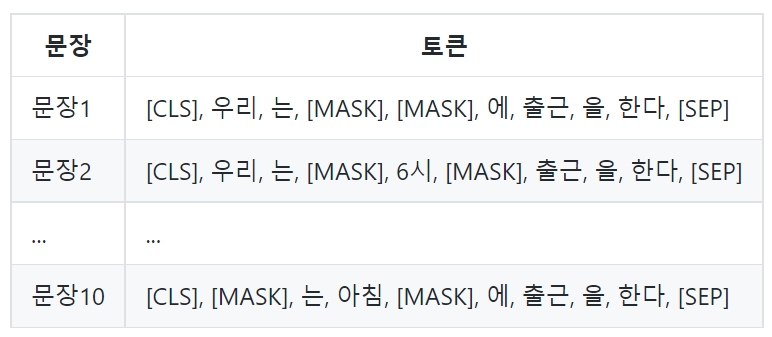

- 모델을 40epoch 까지 학습 이때, epochs별로 다른 마스크가 적용 된 문장을 입력하게 된다.

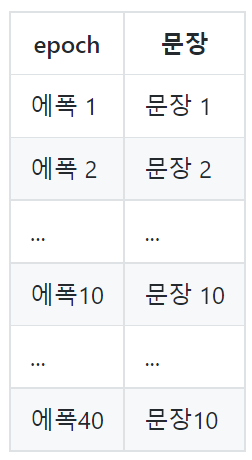

이와 같이 RoBERTa에서는 정적 마스킹 대신 동적 마스킹을 사용하게 된다.

#### NSP 태스크 제거

RoBERTa를 사전학습 할 때는 MLM 태스크만 사용한다.
NSP 태스크의 필요성을 검증하기위해 아래 4가지 실험을 하였다.

- SEGMENT-PAIR + NSP : NSP를 사용해 BERT를 학습 시킴. 입력은 512개 이하의 토큰 쌍으로 구성됨.
- SENTENCE-PAIR + NSP: NSP를 사용해 BERT를 학습 시킴. 이때 입력 값은 한 문서의 연속된 부분 또는 다른 문서에서 추출한 문장을 쌍으로 구성하며, 512개 이하의 토큰 쌍 입력
- FULL SENTENCES : NSP를 사용하지 않고 BERT 학습. 여기서 입력값은 하나 이상의 문서에서 지속적으로 샘플링한 결과 사용. 입력 토큰은 512 토큰. 하나의 문서 마지막 까지 샘플링을 한 이후 다음 문서에서 샘플링 작업을 이어간다.
- DOC SENTENCES : NSP를 사용하지 않고BERT학습. FULL-SENTENCE와 전체적으로 유사한, 입력값은 하나의 문서에서만 샘플링한 결과만 입력. 즉 하나의 문서 마지막 까지 샘플링 한 후에 다음 문서 내용을 사용하지 않음.

##### 태스크 별 모델 성능(F1-SCORE)

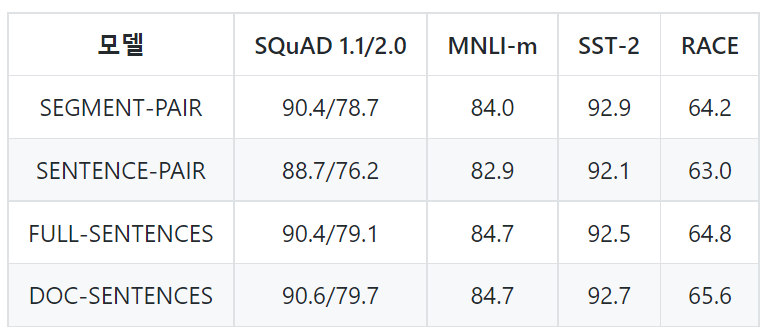

결과를 통해 알 수 있듯이 BERT는 NSP 태스크를 수행하지 않고 학습한 FULL-SENTENCES와 DOC-SENTENCES에서 좋은 성능을 보인다.

결론적으로 RoBERTa에서는 FULL-sentences를 이용해 사전 학습을 진행한다.
입력은 최대 512개 토큰으로 구성되고, 한 문서의 마지막 지점에 도달하면 다음 순서에서 이어서 샘플링 작업을 진행한다.

#### 큰 배치 사이즈 사용

BERT의 경우 256개 배치로 100만 단계 동안 사전 학습을 진행했다. RoBERTa의 경우 더 큰 미니 배치를 적용해 사전 학습을 진행했다. 30만 단계에 대해 8,000개 배치 크기로 사전학습을 진행했다.

#### BBPE 토크나이저 사용

BERT의 경우 워드피스 토크나이저를 사용했다. 워드피스 토크나이저의 경우 BPE와 유사해 likelihood를 기반으로 해 병합 작업을 진행한다. RoBERTa의 경우 BERT와 다르게 BBPE 토크나이저를 사용한다.

BBPE의 경우 기본적으로 BPE와 유사하나 캐릭터 형태가 아닌 바이트 형태의 시퀀스를 사용한다. BERT의 경우 사전 크기가 3만 토큰이고, RoBERTa의 경우 5만 토큰을 사용하였다.

#### RoBERTa에서 임베딩 추출

In [12]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForQuestionAnswering.from_pretrained('roberta-base')
question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
input_ids = tokenizer.encode(question, text)
ret = model(torch.tensor([input_ids]))




Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

In [4]:
print(input_ids)

[0, 12375, 21, 2488, 289, 13919, 116, 2, 2, 24021, 289, 13919, 21, 10, 2579, 29771, 2]


In [5]:
a = [ tokenizer.decode(x) for x in input_ids ]
print(a)

['<s>', 'Who', ' was', ' Jim', ' H', 'enson', '?', '</s>', '</s>', 'Jim', ' H', 'enson', ' was', ' a', ' nice', ' puppet', '</s>']


In [6]:
print(tokenizer.decode(input_ids))

<s>Who was Jim Henson?</s></s>Jim Henson was a nice puppet</s>


In [7]:
print(type(input_ids))

<class 'list'>


In [9]:
print(torch.tensor([input_ids]).shape)

torch.Size([1, 17])


In [10]:
print(start_scores, end_scores)

start_logits end_logits


In [15]:
# print(ret)
print(ret['start_logits'], ret['end_logits'])

tensor([[-0.0922,  0.0337,  0.0717,  0.1801,  0.2185,  0.1175,  0.0337, -0.0859,
          0.0821,  0.0324,  0.1809,  0.0486,  0.0685,  0.1466,  0.1052,  0.1071,
         -0.0859]], grad_fn=<CloneBackward0>) tensor([[ 0.1267,  0.0535,  0.0773, -0.1255, -0.1136,  0.1002,  0.0658,  0.1296,
          0.1175, -0.1170, -0.1023,  0.0817,  0.0103, -0.0194,  0.1395, -0.0864,
          0.1296]], grad_fn=<CloneBackward0>)


In [21]:
all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(all_tokens)
print(torch.argmax(ret['start_logits']))
print(torch.argmax(ret['end_logits'])+1)
answer = ' '.join(all_tokens[torch.argmax(ret['start_logits']) : torch.argmax(ret['end_logits'])+1])
print(answer)

['<s>', 'Who', 'Ġwas', 'ĠJim', 'ĠH', 'enson', '?', '</s>', '</s>', 'Jim', 'ĠH', 'enson', 'Ġwas', 'Ġa', 'Ġnice', 'Ġpuppet', '</s>']
tensor(4)
tensor(15)
ĠH enson ? </s> </s> Jim ĠH enson Ġwas Ġa Ġnice
